<a href="https://colab.research.google.com/github/nikivasan/NLP-Genius-Sentiment-Analysis/blob/main/QTM_340_Final_Project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QTM 340 Final Project 
## Sentiment Analysis by Gender on 2020’s Top Albums
**By Rose Feng and Niki Vasan**


**Here is a list of the albums we will be working with in this project:**

Top 10 Albums by [Female Artists](https://www.billboard.com/charts/year-end/top-billboard-200-albums) (2020)
1. *Folklore* by Taylor Swift (16) 
2. *When We All Fall Asleep, Where Do We Go?* by Billie Eilish (13)
3. *Lover* by Taylor Swift (18)
4. *Over it* by Summer Walker (18)
5. *Manic* by Halsey (16)
6. *Chilombo* by Jhene Aiko (20)
7. *Hot Pink* by Doja Cat (12)
8. *Cuz I Love You* by Lizzo (11) 
9. *Dont Smile At Me* by Billie Eilish (9)
10. *Chromatica* by Lady Gaga (16) 

Top 10 Albums by [Male Artists](https://www.billboard.com/charts/year-end/top-billboard-200-albums) (2020)
1. *Hollywood's bleeding* by Post Malone (17)
2. *My Turn* by Lil Baby (20)
3. *Please Excuse Me For Being Antisocial* by Roddy Ricch (16) 
4. *Fine Line* by Harry Styles (12) 
5. *Eternal Atake* by Lil Uzi Vert (18) 
6. *Shoot For The Stars Aim For The Moon* by Pop Smoke (34) 
7. *After Hours* by The Weekend (14) 
8. *Legends Never Die* by Juice WRLD (22) 
9. *What You See Is What You Get* by Luke Combs (18) 
10. *YHLQMDLG* by Bad Bunny (20) 

# Stage 1: Create Dataset



### Set Up

Our goal is to have 20 directories for each of the top 10 male and female albums of 2020. Each directory will contain text files of the song lyrics of each song in the album (as separate files). In our analysis stage, we will use the documents (text files of song lyrics) as our units of analysis for the sentiment analyzer. This way, we will be able to gather and aggregate our sentiment scores per album, allowing us to compare across albums and ultimately, across genders. 

To accomplish this, we need to scrape the lyrics of each album. We will first need to install the packages we will need to scrape and clean the data. 


In [ ]:
# connect personal gdrive to colab 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install lyricsgenius

In [ ]:
# import necessary libraries 
import pandas as pd
import numpy as np
import json
import requests
import lyricsgenius # library for scraping genius albums 
import json
import re
import os
import io
import gwpy


from bs4 import BeautifulSoup

Next we can save our client access token to a variable for future use. 

In [ ]:
client_access_token = "FWryXFr9A3Quzkz1ygEuPLDDBVjZ03-z3QnCh3cfrV7bhmpiyqklyOK7HanSk4w8" 
genius = lyricsgenius.Genius(client_access_token)

The `lyricsgenius` package acts as a wrapper to the genius API. We will use that to get a json file of the album, that stores information for every track in an album. I'll use Taylor Swift's album *Folklore* as an example. 

### Example Walkthrough

Our process to get the song lyrics has **three** steps. 

1. First, we will parse the json file created above to create a dictionary of the song title and the principal artist (which will be the same for every song in this case) of each song on the album. For the purposes of our analysis, we will not be including featured artists. 

In [ ]:
albumtitle = genius.search_album("Folklore", "Taylor Swift") # use lyricsgenius wrapper to genius api search query
albumtitle.save_lyrics()

folklore_dict = {} # dictionary to store artist name and song title 
with open('Lyrics_folklore.json') as a:
    folklore_json = json.load(a) # load album object 
    song_artist = folklore_json['artist']['name'] # use artist from the album not from song (remove features)
    for track in folklore_json['tracks']: 
      song_title = track['song']['title']
      song_title = re.sub('\u200b', '', song_title) # remove unnecessary characters before song title 
      folklore_dict[song_title] = song_artist # key: song title, value: artist
folklore_dict 

2.  Next, we will iterate through our dictionary of songs and pass them into Genius API's search query feature, so that we can get a dictionary of the urls for each song.  

In [ ]:
folklore_url_dict = {} # dictionary to store urls 

for item in folklore_dict: # iterate through artist and song title 
    song_title = item
    song_artist = folklore_dict[item]
        
    # URL for a search via the Genius API:
    genius_search_url = f'http://api.genius.com/search?q={song_title}&access_token={client_access_token}'

    # API call
    resp = requests.get(genius_search_url)
    data = resp.json() # save as json 
    
    # now search for match w/ artist 
    for song in data['response']['hits']:
        if song['result']['primary_artist']['name'] == song_artist:
            # if there's a match, get the url
            lyrics_url = song['result']['url']
            folklore_url_dict[song_title] = lyrics_url
 
            # break out of for loop if we've got a match 
            break
            
folklore_url_dict

3. Lastly, now that we've got a dictionary of URLs, we can scrape the lyrics for each song and write the output as a text file saved to the appropriate album.


In [ ]:
for item in folklore_url_dict:
    song_title = item
    song_artist = folklore_dict[item]   
    song_url = folklore_url_dict[item]  

    # get the contents of the lyrics page
    resp = requests.get(song_url) 
    html_str = resp.text

    # turn it into a BS object and get the lyrics div
    document = BeautifulSoup(html_str, "html.parser") 
    lyrics_divs = document.find_all("div", attrs={"class": re.compile("^Lyrics__Container.*$")})

    # now let's set up a list to store our lyrics
    lyrics = []

    for div in lyrics_divs:
        lyrics.append(div.get_text(separator='\n'))
    
    # list for clean lyrics 
    cleanest_lyrics = []
    
    for chunk in lyrics:
        # remove square brackets 
        cleaner_chunk = re.sub("\[.*\]", "", chunk)
        # remove leading newlines 
        cleanest_chunk = re.sub("^[\n]{2}","", cleaner_chunk)
        # append the final version to the lyrics list
        cleanest_lyrics.append(cleanest_chunk)

    # store it in a file

    # we'll use the final part of the URL as a filename 
    filename = song_url.replace("https://genius.com/","")
    filename = filename.replace("-lyrics","") + ".txt"
    
    # store the lyrics in the folder for the given album; 
    path = "folklore/" + filename
    
    # write lyrics to file 
    with open(path, "w") as file:
        file.writelines(cleanest_lyrics)
        print("Wrote lyrics to: " + filename)

To make this process easier, we decided to parametrize these steps and place them in a **function** that will take both the album title and artist name as inputs and return a directory with the lyrics of each song in the album. The code for this is below: 

### GetAlbumLyrics Function 

In [ ]:
## Function to get album lyrics 
def getalbumlyrics(album_title, artist_name):

  # ******************************** set default client access token *************************************************
  client_access_token = "FWryXFr9A3Quzkz1ygEuPLDDBVjZ03-z3QnCh3cfrV7bhmpiyqklyOK7HanSk4w8" 
  genius = lyricsgenius.Genius(client_access_token)

  # ***************************** get json file of track info in the album******************************************* 
  albumtitle = genius.search_album(album_title, artist_name) # use lyricsgenius wrapper to genius api search query
  album_title = re.sub("[^a-zA-Z0-9]", "", album_title) # remove spaces in input album title
  albumtitle.save_lyrics() # write json output to a file 

  # ****************************get dictionary of song titles and album artist***************************************
  album_dict = {}
  with open(f'Lyrics_{album_title}.json') as a:
    albumtitle_json = json.load(a) # load album object 
    song_artist = albumtitle_json['artist']['name'] # use artist from the album not from song (remove features)
    for track in albumtitle_json['tracks']: 
      song_title = track['song']['title']
      song_title = re.sub('\u200b', '', song_title) # remove unnecessary characters before song title 
      album_dict[song_title] = song_artist # key: song title, value: artist
  #print(album_dict)
  
   # **************************get a dictionary of songs and lyrics urls*************************************************
  album_url_dict = {} # dictionary to store urls 
  for item in album_dict: # iterate through artist and song title 
      song_title = item
      song_artist = album_dict[item] 
      # URL for a search via the Genius API:
      genius_search_url = f'http://api.genius.com/search?q={song_title}&access_token={client_access_token}'
      # API call
      resp = requests.get(genius_search_url)
      data = resp.json() # save as json 
      # now search for match w/ artist 
      for song in data['response']['hits']:
          if song['result']['primary_artist']['name'] == song_artist:
              # if there's a match, get the url
              lyrics_url = song['result']['url']
              album_url_dict[song_title] = lyrics_url
              # status update so we can make sure we're on the right track...
              print("Matched! Artist: " + song_artist + " and title: " + song_title)
              
              break

  #print(album_url_dict)

  # ************************************************* write lyrics to folder ****************************************
 
  for item in album_url_dict:
    song_title = item
    song_artist = album_dict[item]   
    song_url = album_url_dict[item]  
    # get the contents of the lyrics page
    print("Requesting: " + song_url)
    resp = requests.get(song_url) 
    html_str = resp.text
    # turn it into a BS object and get the lyrics div
    document = BeautifulSoup(html_str, "html.parser") 
    lyrics_divs = document.find_all("div", attrs={"class": re.compile("^Lyrics__Container.*$")})
    # now let's set up a list to store our lyrics
    lyrics = []
    for div in lyrics_divs:
        lyrics.append(div.get_text(separator='\n'))
    # list for clean lyrics 
    cleanest_lyrics = []
    for chunk in lyrics:
        # remove square brackets 
        cleaner_chunk = re.sub("\[.*\]", "", chunk)
        # remove leading newlines 
        cleanest_chunk = re.sub("^[\n]{2}","", cleaner_chunk)
        # append the final version to the lyrics list
        cleanest_lyrics.append(cleanest_chunk)

    # we'll use the final part of the URL as a filename 
    filename = song_url.replace("https://genius.com/","")
    filename = filename.replace("-lyrics","") + ".txt"
    # store the lyrics in the folder for the given album; 
    path = f"{album_title}/" + filename
    print(path)

    # create directory for album 
    if not os.path.exists(f'/content/{album_title}'):
           os.mkdir(f'/content/{album_title}')

    # write lyrics to directory 
    with open(path, "w") as file:
        file.writelines(cleanest_lyrics)
        print("Wrote lyrics to: " + filename)


## **Female Artists**

### 1. Folklore by Taylor Swift

In [ ]:
getalbumlyrics("folklore", "Taylor Swift")

### 2. When We All Fall Asleep, Where Do We Go? By Billie Eilish

In [ ]:
getalbumlyrics("WHEN WE ALL FALL ASLEEP, WHERE DO WE GO", "Billie Eilish")

### 3. Lover by Taylor Swift

In [ ]:
getalbumlyrics("Lover", "Taylor Swift")

Searching for "Lover" by Taylor Swift...
Wrote Lyrics_Lover.json.
Matched! Artist: Taylor Swift and title: I Forgot That You Existed
Matched! Artist: Taylor Swift and title: Cruel Summer
Matched! Artist: Taylor Swift and title: Lover
Matched! Artist: Taylor Swift and title: The Man
Matched! Artist: Taylor Swift and title: The Archer
Matched! Artist: Taylor Swift and title: I Think He Knows
Matched! Artist: Taylor Swift and title: Miss Americana & The Heartbreak Prince
Matched! Artist: Taylor Swift and title: Paper Rings
Matched! Artist: Taylor Swift and title: Cornelia Street
Matched! Artist: Taylor Swift and title: Death by a Thousand Cuts
Matched! Artist: Taylor Swift and title: London Boy
Matched! Artist: Taylor Swift and title: Soon You’ll Get Better
Matched! Artist: Taylor Swift and title: False God
Matched! Artist: Taylor Swift and title: You Need To Calm Down


### 4. Over It By Summer Walker

In [ ]:
getalbumlyrics("Over It", "Summer Walker")

Searching for "Over It" by Summer Walker...
Wrote Lyrics_OverIt.json.
Matched! Artist: Summer Walker and title: Over It
Matched! Artist: Summer Walker and title: Body
Matched! Artist: Summer Walker and title: Drunk Dialing…LODT
Matched! Artist: Summer Walker and title: Potential
Matched! Artist: Summer Walker and title: Fun Girl
Matched! Artist: Summer Walker and title: Stretch You Out
Matched! Artist: Summer Walker and title: Off of You
Matched! Artist: Summer Walker and title: Anna Mae
Matched! Artist: Summer Walker and title: I’ll Kill You
Matched! Artist: Summer Walker and title: Nobody Else
Matched! Artist: Summer Walker and title: Playing Games
Requesting: https://genius.com/Summer-walker-over-it-lyrics
OverIt/Summer-walker-over-it.txt
Wrote lyrics to: Summer-walker-over-it.txt
Requesting: https://genius.com/Summer-walker-body-lyrics
OverIt/Summer-walker-body.txt
Wrote lyrics to: Summer-walker-body.txt
Requesting: https://genius.com/Summer-walker-drunk-dialing-lodt-lyrics
OverIt/

### 5. Manic by Halsey

In [ ]:
getalbumlyrics("Manic", "Halsey")

Searching for "Manic" by Halsey...
Wrote Lyrics_Manic.json.
Matched! Artist: Halsey and title: Ashley
Matched! Artist: Halsey and title: clementine
Matched! Artist: Halsey and title: Graveyard
Matched! Artist: Halsey and title: You should be sad
Matched! Artist: Halsey and title: Forever ... (is a long time)
Matched! Artist: Halsey and title: I HATE EVERYBODY
Matched! Artist: Halsey and title: 3am
Matched! Artist: Halsey and title: Without Me
Matched! Artist: Halsey and title: Finally // beautiful stranger
Matched! Artist: Halsey and title: Alanis’ Interlude
Matched! Artist: Halsey and title: killing boys
Matched! Artist: Halsey and title: Still Learning
Matched! Artist: Halsey and title: 929
Requesting: https://genius.com/Halsey-without-me-lyrics
Manic/Halsey-without-me.txt
Wrote lyrics to: Halsey-without-me.txt
Requesting: https://genius.com/Halsey-clementine-lyrics
Manic/Halsey-clementine.txt
Wrote lyrics to: Halsey-clementine.txt
Requesting: https://genius.com/Halsey-graveyard-lyri

### 6. Chilombo by Jhene Aiko

In [ ]:
getalbumlyrics("Chilombo", "Jhene Aiko")

### 7. Hot Pink by Doja Cat

In [ ]:
getalbumlyrics("Hot Pink", "Doja Cat")

Searching for "Hot Pink" by Doja Cat...
Wrote Lyrics_HotPink.json.
Matched! Artist: Doja Cat and title: Cyber Sex
Matched! Artist: Doja Cat and title: Won’t Bite
Matched! Artist: Doja Cat and title: Rules
Matched! Artist: Doja Cat and title: Bottom Bitch
Matched! Artist: Doja Cat and title: Say So
Matched! Artist: Doja Cat and title: Like That
Matched! Artist: Doja Cat and title: Talk Dirty
Matched! Artist: Doja Cat and title: Addiction
Matched! Artist: Doja Cat and title: Streets
Matched! Artist: Doja Cat and title: Better Than Me
Matched! Artist: Doja Cat and title: Juicy
Requesting: https://genius.com/Doja-cat-cyber-sex-lyrics
HotPink/Doja-cat-cyber-sex.txt
Wrote lyrics to: Doja-cat-cyber-sex.txt
Requesting: https://genius.com/Doja-cat-wont-bite-lyrics
HotPink/Doja-cat-wont-bite.txt
Wrote lyrics to: Doja-cat-wont-bite.txt
Requesting: https://genius.com/Doja-cat-rules-lyrics
HotPink/Doja-cat-rules.txt
Wrote lyrics to: Doja-cat-rules.txt
Requesting: https://genius.com/Doja-cat-bottom-

### 8. Cuz I Love You by Lizzo

In [ ]:
getalbumlyrics("Cuz I Love You", "Lizzo")

Searching for "Cuz I Love You" by Lizzo...
Wrote Lyrics_CuzILoveYou.json.
Matched! Artist: Lizzo and title: Cuz I Love You
Matched! Artist: Lizzo and title: Like a Girl
Matched! Artist: Lizzo and title: Soulmate
Matched! Artist: Lizzo and title: Tempo
Matched! Artist: Lizzo and title: Exactly How I Feel
Matched! Artist: Lizzo and title: Better in Color
Matched! Artist: Lizzo and title: Heaven Help Me
Matched! Artist: Lizzo and title: Lingerie
Requesting: https://genius.com/Lizzo-cuz-i-love-you-lyrics
CuzILoveYou/Lizzo-cuz-i-love-you.txt
Wrote lyrics to: Lizzo-cuz-i-love-you.txt
Requesting: https://genius.com/Lizzo-like-a-girl-lyrics
CuzILoveYou/Lizzo-like-a-girl.txt
Wrote lyrics to: Lizzo-like-a-girl.txt
Requesting: https://genius.com/Lizzo-soulmate-lyrics
CuzILoveYou/Lizzo-soulmate.txt
Wrote lyrics to: Lizzo-soulmate.txt
Requesting: https://genius.com/Lizzo-tempo-lyrics
CuzILoveYou/Lizzo-tempo.txt
Wrote lyrics to: Lizzo-tempo.txt
Requesting: https://genius.com/Lizzo-exactly-how-i-feel

### 9. Don't Smile At Me by Billie Eilish

In [ ]:
getalbumlyrics("dont smile at me", "Billie Eilish")

Searching for "dont smile at me" by Billie Eilish...
Lyrics_dontsmileatme.json already exists. Overwrite?
(y/n): y
Wrote Lyrics_dontsmileatme.json.
Matched! Artist: Billie Eilish and title: COPYCAT
Matched! Artist: Billie Eilish and title: idontwannabeyouanymore
Matched! Artist: Billie Eilish and title: my boy
Matched! Artist: Billie Eilish and title: watch
Matched! Artist: Billie Eilish and title: party favor
Matched! Artist: Billie Eilish and title: bellyache
Matched! Artist: Billie Eilish and title: ocean eyes
Matched! Artist: Billie Eilish and title: hostage
Requesting: https://genius.com/Billie-eilish-copycat-lyrics
dontsmileatme/Billie-eilish-copycat.txt
Wrote lyrics to: Billie-eilish-copycat.txt
Requesting: https://genius.com/Billie-eilish-idontwannabeyouanymore-lyrics
dontsmileatme/Billie-eilish-idontwannabeyouanymore.txt
Wrote lyrics to: Billie-eilish-idontwannabeyouanymore.txt
Requesting: https://genius.com/Billie-eilish-my-boy-lyrics
dontsmileatme/Billie-eilish-my-boy.txt
Wr

### 10. Chromatica by Lady Gaga

In [ ]:
getalbumlyrics("Chromatica", "Lady Gaga")

##**Male Artists**

### 1. Hollywood's Bleeding by Post Malone

In [ ]:
getalbumlyrics("Hollywood's Bleeding", "Post Malone")

Searching for "Hollywood's Bleeding" by Post Malone...
Lyrics_HollywoodsBleeding.json already exists. Overwrite?
(y/n): y
Wrote Lyrics_HollywoodsBleeding.json.
Matched! Artist: Post Malone and title: Hollywood’s Bleeding
Matched! Artist: Post Malone and title: Saint-Tropez
Matched! Artist: Post Malone and title: Enemies
Matched! Artist: Post Malone and title: Allergic
Matched! Artist: Post Malone and title: A Thousand Bad Times
Matched! Artist: Post Malone and title: Circles
Matched! Artist: Post Malone and title: Die For Me
Matched! Artist: Post Malone and title: On the Road
Matched! Artist: Post Malone and title: Take What You Want
Matched! Artist: Post Malone and title: I’m Gonna Be
Matched! Artist: Post Malone and title: Staring at the Sun
Matched! Artist: Post Malone and title: Internet
Matched! Artist: Post Malone and title: Goodbyes
Matched! Artist: Post Malone and title: Wow.
Requesting: https://genius.com/Post-malone-hollywoods-bleeding-lyrics
HollywoodsBleeding/Post-malone-ho

### 2. My Turn by Lil Baby

In [ ]:
getalbumlyrics("My Turn", "Lil Baby")

Searching for "My Turn" by Lil Baby...
Lyrics_MyTurn.json already exists. Overwrite?
(y/n): y
Wrote Lyrics_MyTurn.json.
Matched! Artist: Lil Baby and title: Get Ugly
Matched! Artist: Lil Baby and title: Woah
Matched! Artist: Lil Baby and title: Live Off My Closet
Matched! Artist: Lil Baby and title: Same Thing
Matched! Artist: Lil Baby and title: Emotionally Scarred
Matched! Artist: Lil Baby and title: Commercial
Matched! Artist: Lil Baby and title: Can’t Explain
Matched! Artist: Lil Baby and title: Sum 2 Prove
Matched! Artist: Lil Baby and title: Catch the Sun
Matched! Artist: Lil Baby and title: Consistent
Matched! Artist: Lil Baby and title: Gang Signs
Matched! Artist: Lil Baby and title: Hurtin
Matched! Artist: Lil Baby and title: Solid
Requesting: https://genius.com/Lil-baby-get-ugly-lyrics
MyTurn/Lil-baby-get-ugly.txt
Wrote lyrics to: Lil-baby-get-ugly.txt
Requesting: https://genius.com/Lil-baby-woah-lyrics
MyTurn/Lil-baby-woah.txt
Wrote lyrics to: Lil-baby-woah.txt
Requesting: h

### 3. Please Excuse Me For Being Antisocial by Roddy Ricch

In [ ]:
getalbumlyrics("Please Excuse Me for Being Antisocial", "Roddy Ricch")

Searching for "Please Excuse Me for Being Antisocial" by Roddy Ricch...
Lyrics_PleaseExcuseMeforBeingAntisocial.json already exists. Overwrite?
(y/n): y
Wrote Lyrics_PleaseExcuseMeforBeingAntisocial.json.
Matched! Artist: Roddy Ricch and title: The Box
Matched! Artist: Roddy Ricch and title: Start wit Me
Matched! Artist: Roddy Ricch and title: Perfect Time
Matched! Artist: Roddy Ricch and title: Moonwalkin
Matched! Artist: Roddy Ricch and title: Big Stepper
Matched! Artist: Roddy Ricch and title: Gods Eyes
Matched! Artist: Roddy Ricch and title: Peta
Matched! Artist: Roddy Ricch and title: Boom Boom Room
Matched! Artist: Roddy Ricch and title: Elyse’s Skit
Matched! Artist: Roddy Ricch and title: High Fashion
Matched! Artist: Roddy Ricch and title: Bacc Seat
Matched! Artist: Roddy Ricch and title: Roll Dice
Matched! Artist: Roddy Ricch and title: Prayers to the Trap God
Matched! Artist: Roddy Ricch and title: Tip Toe
Matched! Artist: Roddy Ricch and title: War Baby
Requesting: https://g

### 4. Fine Line by Harry Styles

In [ ]:
getalbumlyrics("Fine Line", "Harry Styles")

Searching for "Fine Line" by Harry Styles...
Wrote Lyrics_FineLine.json.
Matched! Artist: Harry Styles and title: Golden
Matched! Artist: Harry Styles and title: Watermelon Sugar
Matched! Artist: Harry Styles and title: Adore You
Matched! Artist: Harry Styles and title: Lights Up
Matched! Artist: Harry Styles and title: Cherry
Matched! Artist: Harry Styles and title: Falling
Matched! Artist: Harry Styles and title: To Be So Lonely
Matched! Artist: Harry Styles and title: Sunflower, Vol. 6
Matched! Artist: Harry Styles and title: Canyon Moon
Matched! Artist: Harry Styles and title: Treat People With Kindness
Matched! Artist: Harry Styles and title: Fine Line
Requesting: https://genius.com/Harry-styles-golden-lyrics
FineLine/Harry-styles-golden.txt
Wrote lyrics to: Harry-styles-golden.txt
Requesting: https://genius.com/Harry-styles-watermelon-sugar-lyrics
FineLine/Harry-styles-watermelon-sugar.txt
Wrote lyrics to: Harry-styles-watermelon-sugar.txt
Requesting: https://genius.com/Harry-sty

### 5. Eternal Atake by Lil Uzi Vert 

In [ ]:
getalbumlyrics("Eternal Atake", "Lil Uzi Vert")

Searching for "Eternal Atake" by Lil Uzi Vert...
Lyrics_EternalAtake.json already exists. Overwrite?
(y/n): y
Wrote Lyrics_EternalAtake.json.
Matched! Artist: Lil Uzi Vert and title: Baby Pluto
Matched! Artist: Lil Uzi Vert and title: Lo Mein
Matched! Artist: Lil Uzi Vert and title: Silly Watch
Matched! Artist: Lil Uzi Vert and title: You Better Move
Matched! Artist: Lil Uzi Vert and title: Homecoming
Matched! Artist: Lil Uzi Vert and title: I’m Sorry
Matched! Artist: Lil Uzi Vert and title: Celebration Station
Matched! Artist: Lil Uzi Vert and title: Bigger Than Life
Matched! Artist: Lil Uzi Vert and title: Chrome Heart Tags
Matched! Artist: Lil Uzi Vert and title: Bust Me
Matched! Artist: Lil Uzi Vert and title: Prices
Matched! Artist: Lil Uzi Vert and title: Urgency
Matched! Artist: Lil Uzi Vert and title: Venetia
Matched! Artist: Lil Uzi Vert and title: Secure the Bag
Matched! Artist: Lil Uzi Vert and title: P2
Matched! Artist: Lil Uzi Vert and title: Futsal Shuffle 2020
Matched! A

### 6. Shoot For The Stars Aim For The Moon by Pop Smoke

In [ ]:
getalbumlyrics("Shoot for the Stars Aim for the Moon", "Pop Smoke")

Searching for "Shoot for the Stars Aim for the Moon" by Pop Smoke...
Lyrics_ShootfortheStarsAimfortheMoon.json already exists. Overwrite?
(y/n): y
Wrote Lyrics_ShootfortheStarsAimfortheMoon.json.
Matched! Artist: Pop Smoke and title: Bad Bitch from Tokyo (Intro)
Matched! Artist: Pop Smoke and title: Aim for the Moon
Matched! Artist: Pop Smoke and title: For the Night
Matched! Artist: Pop Smoke and title: 44 BullDog
Matched! Artist: Pop Smoke and title: Gangstas
Matched! Artist: Pop Smoke and title: Yea Yea
Matched! Artist: Pop Smoke and title: Creature
Matched! Artist: Pop Smoke and title: Snitching
Matched! Artist: Pop Smoke and title: Make It Rain
Matched! Artist: Pop Smoke and title: The Woo
Matched! Artist: Pop Smoke and title: West Coast Shit
Matched! Artist: Pop Smoke and title: Enjoy Yourself
Matched! Artist: Pop Smoke and title: Mood Swings
Matched! Artist: Pop Smoke and title: Something Special
Matched! Artist: Pop Smoke and title: What You Know Bout Love
Matched! Artist: Pop 

### 7. After Hours by The Weekend

In [ ]:
getalbumlyrics("After Hours", "The Weekend")

Searching for "After Hours" by The Weekend...
Lyrics_AfterHours.json already exists. Overwrite?
(y/n): y
Wrote Lyrics_AfterHours.json.
Matched! Artist: The Weeknd and title: Alone Again
Matched! Artist: The Weeknd and title: Too Late
Matched! Artist: The Weeknd and title: Hardest to Love
Matched! Artist: The Weeknd and title: Scared To Live
Matched! Artist: The Weeknd and title: Snowchild
Matched! Artist: The Weeknd and title: Escape From LA
Matched! Artist: The Weeknd and title: Heartless
Matched! Artist: The Weeknd and title: Faith
Matched! Artist: The Weeknd and title: Blinding Lights
Matched! Artist: The Weeknd and title: In Your Eyes
Matched! Artist: The Weeknd and title: Save Your Tears
Matched! Artist: The Weeknd and title: Repeat After Me (Interlude)
Matched! Artist: The Weeknd and title: After Hours
Matched! Artist: The Weeknd and title: Until I Bleed Out
Requesting: https://genius.com/The-weeknd-alone-again-lyrics
AfterHours/The-weeknd-alone-again.txt
Wrote lyrics to: The-wee

### 8. Legends Never Die by Juice WRLD

In [ ]:
getalbumlyrics("Legends Never Die", "Juic WRLD")

Searching for "Legends Never Die" by Juic WRLD...
Wrote Lyrics_LegendsNeverDie.json.
Matched! Artist: Juice WRLD and title: Anxiety (Intro)
Matched! Artist: Juice WRLD and title: Conversations
Matched! Artist: Juice WRLD and title: Titanic
Matched! Artist: Juice WRLD and title: Bad Energy
Matched! Artist: Juice WRLD and title: Righteous
Matched! Artist: Juice WRLD and title: Blood On My Jeans
Matched! Artist: Juice WRLD and title: Get Through It (Interlude)
Matched! Artist: Juice WRLD and title: Life’s a Mess
Matched! Artist: Juice WRLD and title: I Want It
Matched! Artist: Juice WRLD and title: Fighting Demons
Matched! Artist: Juice WRLD and title: Wishing Well
Matched! Artist: Juice WRLD and title: Screw Juice
Matched! Artist: Juice WRLD and title: Up Up and Away
Matched! Artist: Juice WRLD and title: The Man, The Myth, The Legend (Interlude)
Matched! Artist: Juice WRLD and title: Stay High
Matched! Artist: Juice WRLD and title: Can’t Die
Matched! Artist: Juice WRLD and title: Man of

### 9. What You See Is What You Get by Luke Combs

In [ ]:
getalbumlyrics("What You See Is What You Get", "Luke Combs")

Searching for "What You See Is What You Get" by Luke Combs...
Wrote Lyrics_WhatYouSeeIsWhatYouGet.json.
Matched! Artist: Luke Combs and title: Beer Never Broke My Heart
Matched! Artist: Luke Combs and title: Refrigerator Door
Matched! Artist: Luke Combs and title: Even Though I’m Leaving
Matched! Artist: Luke Combs and title: Lovin’ on You
Matched! Artist: Luke Combs and title: Moon Over Mexico
Matched! Artist: Luke Combs and title: 1, 2 Many
Matched! Artist: Luke Combs and title: Blue Collar Boys
Matched! Artist: Luke Combs and title: New Every Day
Matched! Artist: Luke Combs and title: Every Little Bit Helps
Matched! Artist: Luke Combs and title: Dear Today
Matched! Artist: Luke Combs and title: What You See Is What You Get
Matched! Artist: Luke Combs and title: Does To Me
Matched! Artist: Luke Combs and title: Angels Workin’ Overtime
Matched! Artist: Luke Combs and title: All Over Again
Matched! Artist: Luke Combs and title: Nothing Like You
Matched! Artist: Luke Combs and title: Be

### 10. YHLQMDLG by Bad Bunny

In [ ]:
getalbumlyrics("YHLQMDLG", "Bad Bunn")

Searching for "YHLQMDLG" by Bad Bunn...
Wrote Lyrics_YHLQMDLG.json.
Matched! Artist: Bad Bunny and title: Si Veo a Tu Mamá
Matched! Artist: Bad Bunny and title: La Difícil
Matched! Artist: Bad Bunny and title: Pero Ya No
Matched! Artist: Bad Bunny and title: Yo Perreo Sola
Matched! Artist: Bad Bunny and title: Soliá
Matched! Artist: Bad Bunny and title: La Zona
Matched! Artist: Bad Bunny and title: Vete
Matched! Artist: Bad Bunny and title: A Tu Merced
Matched! Artist: Bad Bunny and title: 25/8
Matched! Artist: Bad Bunny and title: Está Cabrón Ser Yo
Requesting: https://genius.com/Bad-bunny-si-veo-a-tu-mama-lyrics
YHLQMDLG/Bad-bunny-si-veo-a-tu-mama.txt
Wrote lyrics to: Bad-bunny-si-veo-a-tu-mama.txt
Requesting: https://genius.com/Bad-bunny-la-dificil-lyrics
YHLQMDLG/Bad-bunny-la-dificil.txt
Wrote lyrics to: Bad-bunny-la-dificil.txt
Requesting: https://genius.com/Bad-bunny-pero-ya-no-lyrics
YHLQMDLG/Bad-bunny-pero-ya-no.txt
Wrote lyrics to: Bad-bunny-pero-ya-no.txt
Requesting: https://

# Stage 2: Sentiment Analysis

Since we are intersted in learning about the differences in the sentiments in the female artists' lyrics and male artists' lyrics, we will conduct sentinent analysis for each album. To ensure the accuracy and viability of our sentiment analysis result, we will first run a calibration test on the unit of the text being analyzed for Talor Swift's song *August* in the *Folklore* album. Specifically, we will compute the average of compound sentiment scores on a verse level and the compound sentiment score on a song level to see whether we want to analyze the entire song as a single unit or analyze each line.

## **Determining Appropriate Unit of Analysis** 

Before we start our sentiment analysis, we need to determine the appropriate unit to pass into the function. We have two options: 
1. Determine sentiment scores on a verse level and aggregate them at the end using the mean to create one compound score for the song, then aggregate those to create the album score.
2. Compute sentiment scores on the entire song and use that as the basis for creating the album level aggregation. 

We will test out which method seems more appropriate and accurate using both one song and one album.

In [ ]:
# import nltk (nlp library )
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# import VADER sentiment analyzer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer() # create sentiment analyzer object

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Comparison of One Song

**Here is the aggregated verse level compound score for August by Taylor Swift.**

In [ ]:
# Read song artist from folklore
#rose_path = "/content/drive/MyDrive/QTM 340 Final Project/Female Artists/folklore/Taylor-swift-august.txt"
niki_path = "/content/drive/MyDrive/junior year/QTM 340/Final Project/QTM 340 Final Project/Female Artists (1)/folklore/Taylor-swift-august.txt"
with open(niki_path, "r") as file:
    lyrics = file.read() 
print(lyrics)

In [ ]:
# Split the verses in the song and use VADER to compute sentiment scores for each verse
lines = lyrics.split('\n\n') 
# Filter out empty strings in the list
lines = list(filter(None, lines1))

In [ ]:
# Create a list to store all the sentiment scores for each verse
scores_list = []
for line in lines:
    scores = sid.polarity_scores(line)
    scores_list.append((scores['compound']))
    print("\n" + "Comp. score: " + str(scores['compound']) + "\n\n" + line)

In [ ]:
scores_list # view list of verse level scores

[0.0, 0.0516, 0.0, 0.8889, 0.0516, 0.9817]

In [ ]:
print("The average of verse-level sentiment scores is: " + str(sum(scores_list)/len(scores_list)))

The average of verse-level sentiment scores is: 0.3289666666666667


In [ ]:
print ("The average of verse-level sentiment scores removing outliers is: " + str((0.0516 + 0.0516 + 0.8889 + 0.9817 ) / 4))

The average of verse-level sentiment scores removing outliers is: 0.49345


**Now, here is the song-level compound score for the same song.**:

In [ ]:
song_score = sid.polarity_scores(lyrics)
for key in song_score:
    print(key + ": " + str(song_score[key]))

neg: 0.027
neu: 0.848
pos: 0.126
compound: 0.9905


As we can see, these results are drastically different. Lets see if we see these same disparities when iterating over the entire album.

### Comparison in an Entire Album

**Here is the aggregated verse level compound score for Folklore (the album) by Taylor Swift.**

In [ ]:
import glob
import os

In [ ]:
niki_folklore = "/content/drive/MyDrive/junior year/QTM 340/Final Project/QTM 340 Final Project/Female Artists (1)/folklore"
path = niki_folklore
os.chdir(path) # change path 


# need to add a list and then get the average for each song and add that to the dictionary 
folklore_dict = {}
for file in os.listdir():
    if file.endswith(".txt"):
        file_path = f"{path}/{file}"
        with open(file_path, 'r') as f:
          verse_scores = []
          lyrics = f.read()
          song = file.replace("Taylor-swift-","")
          song = song.replace(".txt", "")
          lines = lyrics.split('\n\n') 
          lines = list(filter(None, lines))
          for line in lines:
            scores = sid.polarity_scores(line)
            verse_scores.append((scores['compound']))
            folklore_dict[song] = sum(verse_scores)/len(verse_scores)
            

folklore = pd.DataFrame.from_dict(folklore_dict, orient='index')


**Now, here is the song-level compound score for the same album.**

In [ ]:
path = niki_folklore
score_folklore_list = []
for filename in glob.glob(os.path.join(path, '*.txt')):
   with open(os.path.join(os.getcwd(), filename), 'r') as f: 
     lyrics = f.read()
     score_folklore = sid.polarity_scores(lyrics)
     score_folklore_list.append(score_folklore['compound'])

print(score_folklore_list)

[-0.5022, -0.9862, 0.8566, 0.9825, -0.9825, 0.9572, 0.9808, -0.9012, 0.947, -0.9813, 0.9867, 0.9905, 0.9081, 0.9908, -0.8987, 0.2981]


**Let's compare these two in a dataframe.**

In [ ]:
folklore['Song-Level'] = score_folklore2_list
folklore = folklore.rename(columns={0:'Verse-Level'})
folklore['Absolute Difference'] =  np.abs(folklore['Song-Level']) - np.abs(folklore['Verse-Level'])
folklore['Absolute Difference'] = np.abs(folklore['Absolute Difference'])
folklore

,Verse-Level,Song-Level,Absolute Difference
peace,-0.590100,-0.5022,0.087900
mad-woman,-0.341029,-0.9862,0.645171
mirrorball,0.415800,0.8566,0.440800
the-last-great-american-dynasty,0.464533,0.9825,0.517967
hoax,-0.515240,-0.9825,0.467260
betty,0.183978,0.9572,0.773222
the-1,0.480243,0.9808,0.500557
this-is-me-trying,-0.102214,-0.9012,0.798986
invisible-string,0.326950,0.9470,0.620050
my-tears-ricochet,-0.329760,-0.9813,0.651540


We can see that there are differences between the two approaches. Passing in the entire song skews to an extreme (either positive or negative), while using the verse as the unit of analysis skews more negative. We can now use a different approach to clarify what might be the best approach.

### Human Labeling Classification 

One way we will be determining what the appropriate unit of analysis is for the songs is by labeling songs we are familiar with on a 5 point categorical scale. We will associate each categorical label with a continuous interval on our compound sentiment score that ranges from -1.0 to 1.0. We will then train those songs both on a verse level and on a song level, and see what approach better classifies the model appropriately. 



---




The scale that we will be using is:


Strongly negative -> Moderately negative -> **Neutral** -> Moderately positive -> Strongly Positive

Quantitatively, the intervals will look like: 

$$[1,-0.6) -> [-0.6,-0.2) -> [-0.2,0.2) -> [0.2,0.6) -> [0.6,1.0]$$

We will be using 5 songs from the Male albums, and 5 songs from the Female albums. We will have two songs that fit each category.


**Male Artist Songs**






| Song                 | Artist       | Human Label         |   |   |
|----------------------|--------------|---------------------|---|---|
| Hollywood's Bleeding | Post Malone  | Strongly Negative   |   |   |
| Can't Die            | Juice WRLD   | Moderately Negative |   |   |
| For the Night        | Pop Smoke    | Neutral             |   |   |
| High Fashion         | Roddy Ricch  | Moderately Positive |   |   |
| Watermelon Sugar     | Harry Styles | Moderately Negative |   |   |

**Female Artist Songs**

| Song                               | Artist        | Human Label         |
|------------------------------------|---------------|---------------------|
| When the Party's Over              | Billie Eilish | Strongly Negative   |
| Playing Games                      | Summer Walker | Moderately Negative |
| Juicy                              | Doja Cat      | Neutral             |
| Happiness Over Everything (H.O.E.) | Jhene Aiko    | Moderately Positive |
| Soulmate                           | Lizzo         | Strongly Positive   |

First, we will be defining a function that will provide both a song level and verse level output for each song we pass in.

In [ ]:
def get_sentiment(gender, album_title, artist, song):
  # clean up parameters 
  album_title = re.sub("[^a-zA-Z0-9]", "", album_title)
  gender = gender.title()
  song = song.lower() 
  with open(f'/content/drive/MyDrive/junior year/QTM 340/Final Project/QTM 340 Final Project/{gender} Artists/{album_title}/{artist}-{song}.txt') as a:
    lyrics = a.read()
    # Song Level Analysis 
    scores = sid.polarity_scores(lyrics)
    song_total = scores['compound']

    # Verse Level Analysis 
    verse_scores = []
    lines = lyrics.split('\n\n') 
    lines = list(filter(None, lines))
    for line in lines:
      scores = sid.polarity_scores(line)
      verse_scores.append((scores['compound']))
      verse_total = sum(verse_scores)/len(verse_scores)
  
  return song_total, verse_total


Next, we define a few different lists that provide information about the song name, artist name and input class so that we can add it to a dataframe at the end. 

In [ ]:
# 
verse = [] # Add Verse Scores
song = [] # Add Song level Scores 
song_names = ["Hollywood's Bleeding", "Can't Die", "For the Night", "High Fashion", "Watermelon Sugar", "When the Party's Over", "Playing Games", "Juicy", "Happiness Over Everything (H.O.E)", "Soulmate"]
hcl_class = ['Strongly Negative', 'Moderately Negative', 'Neutral', 'Moderately Positive', 'Strongly Positive', 'Strongly Negative', 'Moderately Negative', 'Neutral', 'Moderately Positive', 'Extremely Positive']
song_artists = ["Post Malone", "Juice WRLD", "Pop Smoke", "Roddy Ricch", "Harry Styles", "Billie Eilish", "Summer Walker", "Doja Cat", "Jhene Aiko", "Lizzo"]

Now we call this function 10 different times and append the song and verse level outputs to their respective lists in the order of the songs in the list above.

In [ ]:
hollywood = get_sentiment('Male', 'HollywoodsBleeding', 'Post-malone', 'hollywoods-bleeding')
song.append(hollywood[0]) 
verse.append(hollywood[1])

#/content/drive/MyDrive/QTM 340 Final Project/Male Artists/LegendsNeverDie/Juice-wrld-cant-die.txt
Cantdie_sentiment = get_sentiment('Male','LegendsNeverDie', 'Juice-wrld', 'cant-die')
song.append(Cantdie_sentiment[0]) 
verse.append(Cantdie_sentiment[1])

#/content/drive/MyDrive/QTM 340 Final Project/Male Artists/ShootfortheStarsAimfortheMoon/Pop-smoke-for-the-night.txt
forthenight_sentiment = get_sentiment('Male','ShootfortheStarsAimfortheMoon', 'Pop-smoke', 'for-the-night')
song.append(forthenight_sentiment[0]) 
verse.append(forthenight_sentiment[1])

#/content/drive/MyDrive/QTM 340 Final Project/Male Artists/PleaseExcuseMeforBeingAntisocial/Roddy-ricch-high-fashion.txt
highfashion_sentiment = get_sentiment('Male','PleaseExcuseMeforBeingAntisocial', 'Roddy-ricch', 'high-fashion')
song.append(highfashion_sentiment[0]) 
verse.append(highfashion_sentiment[1])

# /content/drive/MyDrive/QTM 340 Final Project/Male Artists/FineLine/Harry-styles-watermelon-sugar.txt
watermelonsugar_sentiment = get_sentiment('Male','FineLine', 'Harry-styles', 'watermelon-sugar')
song.append(watermelonsugar_sentiment [0]) 
verse.append(watermelonsugar_sentiment [1])

#/content/drive/MyDrive/QTM 340 Final Project/Female Artists/WHENWEALLFALLASLEEPWHEREDOWEGO/Billie-eilish-when-the-partys-over.txt
thepartysover_sentiment = get_sentiment('Female','WHENWEALLFALLASLEEPWHEREDOWEGO', 'Billie-eilish', 'when-the-partys-over')
song.append(thepartysover_sentiment[0]) 
verse.append(thepartysover_sentiment[1])

#/content/drive/MyDrive/QTM 340 Final Project/Female Artists/OverIt/Summer-walker-playing-games.txt
playinggames_sentiment = get_sentiment('Female','OverIt', 'Summer-walker', 'playing-games')
song.append(playinggames_sentiment[0]) 
verse.append(playinggames_sentiment[1])

#/content/drive/MyDrive/QTM 340 Final Project/Female Artists/HotPink/Doja-cat-juicy.txt
juicy_sentiment = get_sentiment('Female','HotPink', 'Doja-cat', 'juicy')
song.append(juicy_sentiment [0]) 
verse.append(juicy_sentiment [1])

#/content/drive/MyDrive/QTM 340 Final Project/Female Artists/Chilombo/Jhene-aiko-happiness-over-everything-hoe.txt
happinessovereverythinghoe_sentiment = get_sentiment('Female','Chilombo', 'Jhene-aiko', 'happiness-over-everything-hoe')
song.append(happinessovereverythinghoe_sentiment[0]) 
verse.append(happinessovereverythinghoe_sentiment[1])

#/content/drive/MyDrive/QTM 340 Final Project/Female Artists/CuzILoveYou/Lizzo-soulmate.txt
soulmate_sentiment = get_sentiment('Female','CuzILoveYou', 'Lizzo', 'soulmate')
song.append(soulmate_sentiment[0]) 
verse.append(soulmate_sentiment[1])

To better visualize the results, we will be adding the songs (plus their relevant info) and their outputs to a dataframe. 

In [ ]:
hl_data = pd.DataFrame(data=song_names)
hl_data['Song-Artists'] = song_artists 
hl_data['HL Class'] = hcl_class 
hl_data['Song-Level-Scores'] = song 
hl_data['Verse-Level-Scores'] = verse 
hl_data['Absolute-Difference'] = np.abs(hl_data['Song-Level-Scores']) - np.abs(hl_data['Verse-Level-Scores'])
hl_data = hl_data.rename(columns={0:'Song-Names'}) 
accurate_y_n = ['N', 'N', 'N', 'Y', 'Y', 'N', 'N', 'N', 'N', 'Y']
hl_data['Accurate-Y-N'] = accurate_y_n
hl_data


,Song-Names,Song-Artists,HL Class,Song-Level-Scores,Verse-Level-Scores,Absolute-Difference,Accurate-Y-N
0,Hollywood's Bleeding,Post Malone,Strongly Negative,0.7503,-0.244050,0.506250,N
1,Can't Die,Juice WRLD,Moderately Negative,0.9898,0.417250,0.572550,N
2,For the Night,Pop Smoke,Neutral,-0.9979,-0.914933,0.082967,N
3,High Fashion,Roddy Ricch,Moderately Positive,0.9482,0.109150,0.839050,Y
4,Watermelon Sugar,Harry Styles,Strongly Positive,0.9502,0.203763,0.746438,Y
5,When the Party's Over,Billie Eilish,Strongly Negative,0.9964,0.452560,0.543840,N
6,Playing Games,Summer Walker,Moderately Negative,0.9180,0.436200,0.481800,N
7,Juicy,Doja Cat,Neutral,0.9977,0.887420,0.110280,N
8,Happiness Over Everything (H.O.E),Jhene Aiko,Moderately Positive,-0.9879,-0.801300,0.186600,N
9,Soulmate,Lizzo,Extremely Positive,0.9999,0.793844,0.206056,Y


In [ ]:
# Average Absolute Difference Across All Observations
np.mean(hl_data['Absolute-Difference'])

0.42758297222222225

After conducting both of these analyses, we can clearly see that the song-level scores are completely inaccurate and differs drastically compared to an aggregate of the verse-level scores. 

However, the verse level scores did not also fit our human labeling. This may be an indicator that this sentiment model is not producing relevant outputs for our data, either due to our use of the model and its paramters our the kind of data we are using. Another possibility, that is also likely impacting these results, is that our perception of the sentiment of songs is largely based on the beat, track, and voice of the artists. This textual processor has no access to any of that information. Thus, for example, perhaps the actual *lyrics* of some of these songs are positive, but we classified them as negative based on our experience listening to the music.

Because of this, we will still continue with using the sentiment model on all of our albums to analyze gender based disparities moving forward, but we will also bear these discrepancies in mind.

## **Conducting the Sentiment Analysis**

Because our human labeling did not correlate very well to either sentiment analysis score, we have decided to go ahead and use both scores in our analysis, averaging it out over albums and then over gender. We are taking into account that the the song level score tends to skew extremely positive, so we will likely end up using the verse level score as the results we report on. 


We understand that this approach leaves a lot of room for error - and that's okay. We will discuss this in the "next steps" portion of our paper! 


For now, to begin with, we will defining a few helper functions. 

The first is a function similar as before, which will extract the verse-level sentiment from a given album.

In [ ]:
def get_verse_sentiment(gender, album_title, artist):
  # clean up parameters 
  album_title = re.sub("[^a-zA-Z0-9]", "", album_title) # standardize with genius API output 
  gender = gender.title() 
  artist = str(artist)
  # path = f'/content/drive/MyDrive/QTM 340 Final Project/{gender} Artists/{album_title}'
  # Niki's path
  path = f'/content/drive/MyDrive/junior year/QTM 340/Final Project/QTM 340 Final Project/{gender} Artists/{album_title}'
  os.chdir(path) 
  dict1 = {}
  for file in os.listdir(): # iterate through album directory 
    if file.endswith(".txt"):
      file_path = f"{path}/{file}"
      with open(file_path, 'r') as f:
        verse_scores = []
        lyrics = f.read()
        # song title 
        song = file.replace(artist,"")
        song = song.replace(".txt", "")
        song = song.replace("-", "")
        lines = lyrics.split('\n\n') 
        lines = list(filter(None, lines))
        # score
        for line in lines:
          scores = sid.polarity_scores(line)
          verse_scores.append((scores['compound']))
          dict1[song] = sum(verse_scores)/len(verse_scores)  
  album_title = pd.DataFrame.from_dict(dict1, orient='index')
  album_title = album_title.rename(columns={0:'Verse-Level'})
  return album_title
  #return album_title['Verse-Level'].mean()

Next, we will create a separate function that will calculate the song-level sentiment from a given album.

In [ ]:
def get_song_sentiment(gender, album_title, artist):
  # path = f'/content/drive/MyDrive/QTM 340 Final Project/{gender} Artists/{album_title}'
  # Niki's path
  path = f'/content/drive/MyDrive/junior year/QTM 340/Final Project/QTM 340 Final Project/{gender} Artists/{album_title}'
  score_df = {}
  for file in os.listdir():
    if file.endswith(".txt"):
      file_path = f"{path}/{file}"
      with open(file_path, 'r') as f: 
        lyrics = f.read()
        # title
        song = file.replace(artist,"")
        song = song.replace(".txt", "")
        song = song.replace("-", "")
        # song score
        score = sid.polarity_scores(lyrics)
        score_df[song] = score['compound']
  score_df = pd.DataFrame.from_dict(score_df, orient='index')
  score_df = score_df.rename(columns={0:'Song-Level'})
  return score_df
  #return score_df['Song-Level'].mean()

Here is a simple function to cast the output of each album into a dataframe

In [ ]:
def create_df(gender, album_title, artist):
  verse = get_verse_sentiment(gender,album_title, artist)
  song = get_song_sentiment(gender, album_title, artist)
  temp = pd.concat([verse, song], axis = 1)
  verse_mean = temp['Verse-Level'].mean()
  song_mean = temp['Song-Level'].mean() 
  data = {'Verse-Level-Average': [verse_mean],
          'Song-Level-Average': [song_mean]}
  df = pd.DataFrame(data)
  df['Album'] = album_title
  cols = df.columns.tolist()
  cols = cols[-1:] + cols[:-1]
  df = df[cols]
  return df

**Here is what this looks like on our data.**
Ladies first :)


In [ ]:
f1 = create_df('Female', 'folklore', 'Taylor-swift')
f2 = create_df('Female', 'WHENWEALLFALLASLEEPWHEREDOWEGO', "Billie-eilish")
f3 = create_df('Female', 'Lover', "Taylor-swift")
f4 = create_df('Female', 'OverIt', 'Summer-walker')
f5 = create_df('Female', 'Manic', 'Halsey')
f6 = create_df('Female', 'Chilombo', 'Jhene-aiko')
f7 = create_df('Female', 'HotPink', 'Doja-cat')
f8 = create_df('Female', 'CuzILoveYou', 'Lizzo')
f9 = create_df('Female', 'dontsmileatme', 'Billie-eilish')
f10 =create_df('Female','Chromatica', 'Lady-gaga')

In [ ]:
female_scores = pd.concat([f1,f2,f3,f4,f5,f6,f7,f8,f9,f10])
female_scores

,Album,Verse-Level-Average,Song-Level-Average
0,folklore,0.154577,0.224569
0,WHENWEALLFALLASLEEPWHEREDOWEGO,0.172262,0.215015
0,Lover,0.126749,0.201129
0,OverIt,0.353774,0.341845
0,Manic,0.169664,0.099992
0,Chilombo,0.236165,0.187667
0,HotPink,0.349611,0.620627
0,CuzILoveYou,0.326391,0.367350
0,dontsmileatme,-0.141817,-0.435900
0,Chromatica,0.089364,0.167908


Next, we can do the men.

In [ ]:
m1 = create_df('Male', 'HollywoodsBleeding', 'Post-malone')
m2 = create_df('Male', 'MyTurn', 'Lil-baby')
m3 = create_df('Male', 'PleaseExcuseMeforBeingAntisocial','Roddy-rich')
m4 = create_df('Male', 'FineLine', 'Harry-styles')
m5 = create_df('Male', 'EternalAtake', 'Lil-uzi-vert')
m6 = create_df('Male', 'ShootfortheStarsAimfortheMoon','Pop-smoke')
m7 = create_df('Male', 'AfterHours', 'The-weekend')
m8 = create_df('Male', 'LegendsNeverDie', 'Juice-wrld')
m9 = create_df('Male', 'WhatYouSeeIsWhatYouGet', 'Luke-combs')
m10 = create_df('Male', 'YHLQMDLG', 'Bad-bunny')

In [ ]:
male_scores = pd.concat([m1,m2,m3,m4,m5,m6,m7,m8,m9,m10])
male_scores

,Album,Verse-Level-Average,Song-Level-Average
0,HollywoodsBleeding,-0.123975,-0.089721
0,MyTurn,-0.361158,-0.499138
0,PleaseExcuseMeforBeingAntisocial,-0.169493,-0.177093
0,FineLine,0.134158,0.328936
0,EternalAtake,0.036813,-0.391412
0,ShootfortheStarsAimfortheMoon,0.146611,0.237026
0,AfterHours,-0.084088,-0.218371
0,LegendsNeverDie,0.030895,-0.123156
0,WhatYouSeeIsWhatYouGet,0.345420,0.596062
0,YHLQMDLG,-0.443686,-0.946820


We can see that there are obvious differences between the average album-level sentiment scores of the women and men, just by looking at them. Let's take a look at the averages across gender and see what we find. 

In [ ]:
print('The average verse-level sentiment score of female artists is ' + str(round(female_scores['Verse-Level-Average'].mean(),2)))

The average verse-level sentiment score of female artists is 0.15


In [ ]:
print('The average song-level sentiment score of female artists is ' + str(round(female_scores['Song-Level-Average'].mean(),2)))

The average song-level sentiment score of female artists is 0.32


In [ ]:
print('The average verse-level sentiment score of male artists is ' + str(round(male_scores['Verse-Level-Average'].mean(),2)))

The average verse-level sentiment score of male artists is -0.05


In [ ]:
print('The average song-level sentiment score of male artists is ' + str(round(male_scores['Song-Level-Average'].mean(),2)))

The average song-level sentiment score of male artists is -0.13


Among the 2020's top 10 albums from female artists, the average verse-level sentiment score of women's lyrics is around 0.15, suggesting the songs written by female artists are nearly neutral. The average song-level sentiment score of women's lyrics, which is 0.32, however, 
suggests that the lyrics written by female artists are moderately positive. 

Among the top 10 albums created by male artists, the mean verse-level sentiment score is around -0.05, which is nearly neutral. The mean song-level score, - 0.13, is slghtly more negative but still falls into the "neutral" category.

Comparing these sentiment scores together, we can conclude that songs in the most streamed albums from female artists are more positive in nature, but the lyrics in men's albums are a little more negative. The differences between women's lyrics and men's lyrices are subtle, but they are still telling about the relationship between streaming behavior and gender biases. Audiences prefer to listen to more positive songs from female artists but slightly negative songs created by male artists. This finding can also be indicative of the gender norms in music composition, suggesting that female artists tend to write more positive songs and male artists tend to create more negative and neutral music.

# Stage 3: Exploring our Data + Next Steps

### Visualizations 

Let's compare the verse level sentiment scores of both men and women in histograms.

In [ ]:
import matplotlib.pyplot as plt
import seaborn

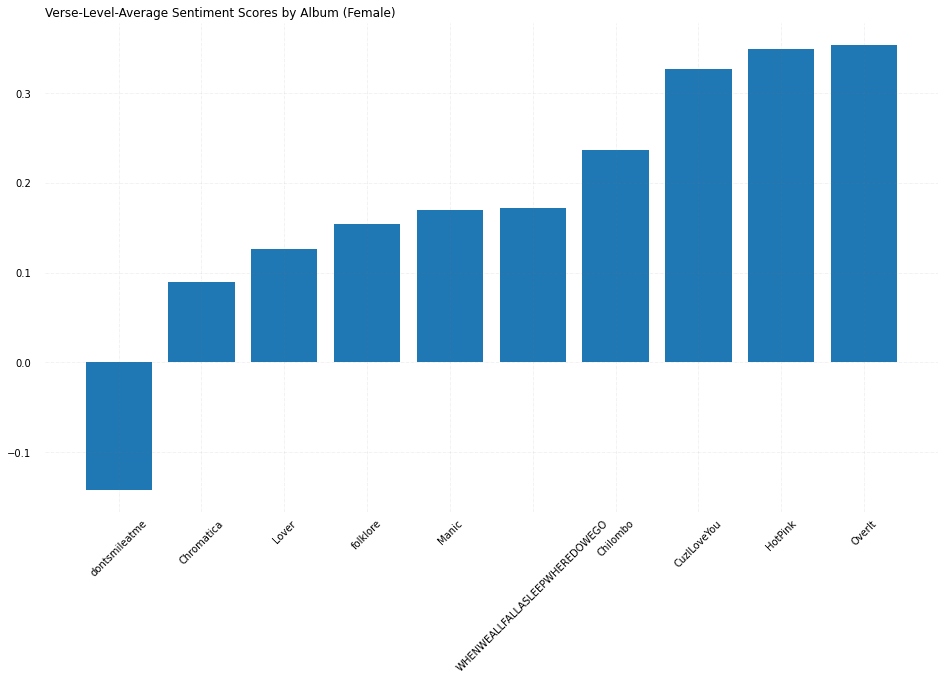

FileNotFoundError: ignored

In [ ]:
female_scores = female_scores.sort_values('Verse-Level-Average')
albums = female_scores['Album']
verse_scores = female_scores['Verse-Level-Average']

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.bar(albums, verse_scores)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 2.5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Rotate x axis labels
plt.xticks(rotation = 45)

 
# Add Plot Title
ax.set_title('Verse-Level-Average Sentiment Scores by Album (Female)',
             loc ='left', )
 
# Show Plot
plt.show()

# Save Image
#from google.colab import files
#files.download("female_distributions")

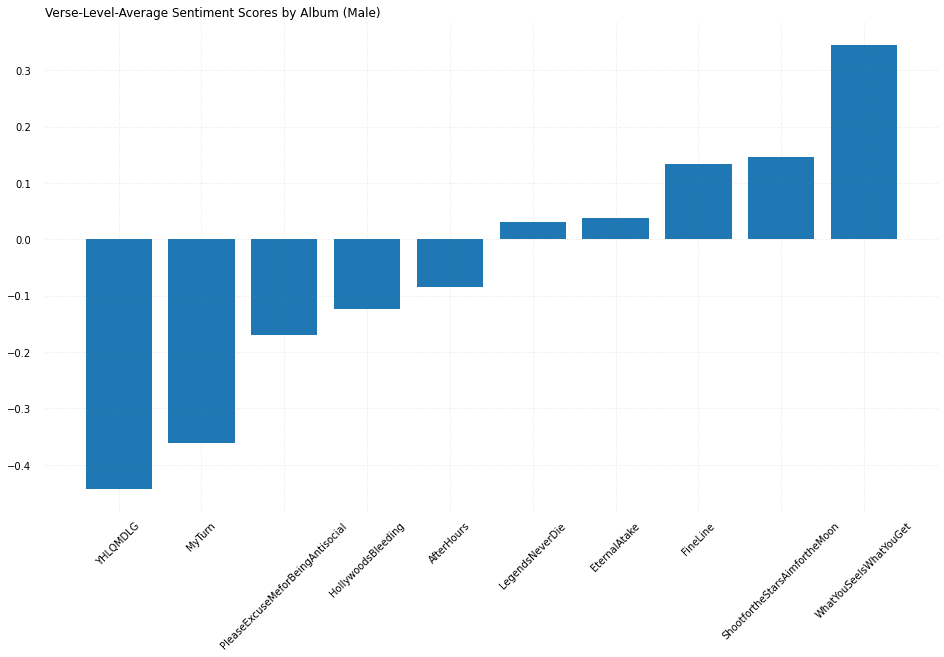

In [ ]:
male_scores = male_scores.sort_values('Verse-Level-Average')
albums = male_scores['Album']
verse_scores = male_scores['Verse-Level-Average']

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.bar(albums, verse_scores)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# Rotate x axis labels
plt.xticks(rotation = 45)

# Add Plot Title
ax.set_title('Verse-Level-Average Sentiment Scores by Album (Male)',
             loc ='left', )
 
# Show Plot
plt.show()